<a href="https://colab.research.google.com/github/andrerubeis/Intent-Detection/blob/main/final_coefficient_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
colab = True

if colab == True:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!nvidia-smi

Wed Feb  1 18:47:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Loading Dataset

In [5]:
colab = True

if colab == True:
  path_dev= r'/content/development.csv'
  path_eval= r'/content/evaluation.csv'

else:
  path_dev = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'
  path_eval = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/evaluation.csv'

df_development = pd.read_csv(path_dev)
df_evaluation = pd.read_csv(path_eval)

df_development

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40


## 2. Exploratory Analysis


In [6]:
split_in_matrices = False
threshold_VAD = 30
nc = 15

In this phase we perform exploratory analysis to check the presence of missing values, outliers and class distribution in our dataset.

### 2.1 Missing Values

In [7]:
df_development.isna().sum()

Id                                       0
path                                     0
speakerId                                0
action                                   0
object                                   0
Self-reported fluency level              0
First Language spoken                    0
Current language used for work/school    0
gender                                   0
ageRange                                 0
dtype: int64

As can be seen no missing values are present in our dataset so there is no need to apply any kind of estimation technique.

### 2.2. Existing Intent Combinations


Evaluate all the existing combinations in the dataset

In this step we construct the _label_ column containing a label for each audio composed by the tuple _(action, object)_.

In [8]:
#Evaluate all the existing combinations in the dataset
df_increase = df_development[df_development['action']=='increase']
df_increase.object.value_counts()

volume    2614
heat      1209
Name: object, dtype: int64

In [9]:
#Evaluate all the existing combinations in the dataset
df_decrease = df_development[df_development['action']=='decrease']
df_decrease.object.value_counts()

volume    2386
heat      1189
Name: object, dtype: int64

In [10]:
#Evaluate all the existing combinations in the dataset
df_change_language = df_development[df_development['action']=='change language']
df_change_language.object.value_counts()

none    1113
Name: object, dtype: int64

In [11]:
#Evaluate all the existing combinations in the dataset
df_activate = df_development[df_development['action']=='activate']
df_activate.object.value_counts()

music    791
Name: object, dtype: int64

In [12]:
#Evaluate all the existing combinations in the dataset
df_deactivate = df_development[df_development['action']=='deactivate']
df_deactivate.object.value_counts()

lights    552
Name: object, dtype: int64

In [13]:
del df_increase, df_decrease, df_change_language, df_activate, df_deactivate #delete tmp datframes to free RAM

Combinations of actions expressed by humans in the dataset found are the following:
1. increase volume
2. increase heat
3. decrease volume
4. decrease heat
5. change language
6. activate music
7. deactivate lights

According to this, starting from this dataset a new one can be generated containing the audio file with the corresponding label aside referring to the desired action.

### 2.3 Adding _labels_ column
Add a column called labels where in correspondance of each combination has the respective label (ex. if the row has action=_increase_ and object=_heat_ has label _increaseheat_)

In [14]:
#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development['labels']=0

#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume'), 'labels']='increasevolume'
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'heat'), 'labels']='increaseheat'

df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'volume'), 'labels']='decreasevolume'
df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'heat'), 'labels']='decreaseheat'

df_development.loc[(df_development['action'] == 'change language') & (df_development['object'] == 'none'), 'labels']='change languagenone'

df_development.loc[(df_development['action'] == 'activate') & (df_development['object'] == 'music'), 'labels']='activatemusic'
df_development.loc[(df_development['action'] == 'deactivate') & (df_development['object'] == 'lights'), 'labels']='deactivatelights'

df_development
#df_development.labels.value_counts() #check

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,change languagenone
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,activatemusic
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,deactivatelights
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,increasevolume
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,increasevolume
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,decreasevolume
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights


Let's see the distribution of classes.

In [15]:
df_development.labels.value_counts()

increasevolume         2614
decreasevolume         2386
increaseheat           1209
decreaseheat           1189
change languagenone    1113
activatemusic           791
deactivatelights        552
Name: labels, dtype: int64

### 2.4 Acquire audio files and generate pickle files.

Now we are ready to go further and create a new dataset called _df_pd_ derived by _df_development_ containing at each row the audio in time domain stored in _df_development_ path column.

In [16]:
#Depending on there the code is run, path_working directory assumes different strings
if colab == True:
  path_working_directory= r'/content/drive/MyDrive/'
else:
  path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings_dev = df_development['path']
paths_recordings_eval = df_evaluation['path']

Comment the cell below if you already have the pickle file of the dataset, otherwise decomment it to acquire the audio files inside the path _path_working_directory + paths_recordings_dev_.

In [17]:
# signals = []
# ids = []
# genders = []
# ageRanges = []
# labels = []

# for i, row in df_development.iterrows():
#     path = row['path']
#     gender = row['gender']
#     ageRange = row['ageRange']
#     label = row['labels']

#     file_path = f'{path_working_directory}/{path}'
#     print(file_path)
#     signal, sr = librosa.load(file_path)

#     ids.append(i)
#     signals.append(signal)
#     genders.append(gender)
#     ageRanges.append(ageRange)
#     labels.append(label)

# df_pd = pd.DataFrame()
# df_pd['Id'] = ids
# df_pd['audio'] = signals
# df_pd['gender'] = genders
# df_pd['ageRange'] = ageRanges
# df_pd['label'] = labels
# df_pd

Generate the pickle file.

In [18]:
# name_file_dev = r'/df_pd.pickle'
# name_file_eval = r'/df_pd_eval.pickle'

# print( path_working_directory+name_file_dev)
# with open(path_working_directory+name_file_dev, "wb") as output_file:
#     pickle.dump(df_pd, output_file)

# print( path_working_directory+name_file_eval)
# with open(path_working_directory+name_file_eval, "wb") as output_file:
#     pickle.dump(df_pd_eval, output_file)

Load the pickle file.

In [19]:
name_file_dev = r'/df_pd.pickle'
name_file_eval = r'/df_pd_eval.pickle'

with open(path_working_directory+name_file_dev, 'rb') as f:
        df_pd = pickle.load(f)

with open(path_working_directory+name_file_eval, 'rb') as f:
        df_pd_eval = pickle.load(f)
df_pd

,Id,audio,gender,ageRange,label
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
...,...,...,...,...,...
9849,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume
9850,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights
9851,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights
9852,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights


### 2.5 Distribution of audios length

After having stored the audio files we analyze their distribution length. The expression below are helpful to pass from number of samples to seconds and viceversa.

 
$ seconds = \frac{n\_samples}{sr}$

$n\_samples = seconds*sr$


See distribution of audio length

Text(0, 0.5, 'Count')

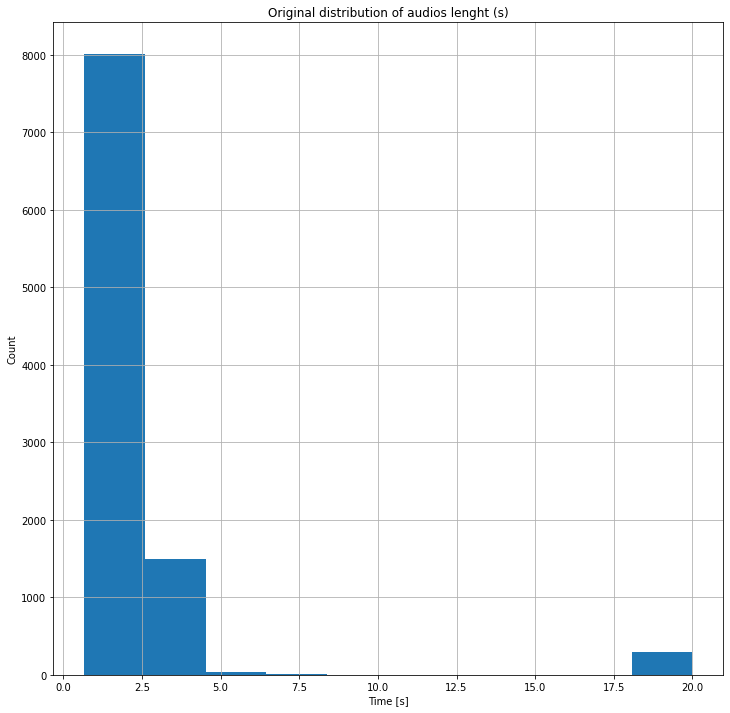

In [20]:
sr = 22050
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item in df_pd.audio:
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
#   Decomment if you are interested in retrieve indexes of audio within a specific range 
    # if len(item)/sr  >= 5 and len(item)/sr  <=7.5:
    #     indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)

#Plot the distribution
plt.figure(figsize=(12,12))
plt.title("Original distribution of audios lenght (s)")
length_audios_seconds.hist()
plt.xlabel("Time [s]")
plt.ylabel("Count")
#print(length_audios_seconds)


### 3. Pre-Processing

According to several papers focused on audio classification, VDA is among one of the most preprocessing techinque adopted which aims to trim all the silence parts away from audio files.

To apply it, we will use _trim_ and _split_ librosa functions.

- _trim_: cut silence frames at the beginning and in the end of an audio file.
- _split_: saves the indexes (start, stop) of each non-silent frame in the audio file.

#### 3.1 Trim

In [21]:
trim_audios = []
for i, audio in enumerate(df_pd.audio):
    audio_trim = librosa.effects.trim(audio, top_db=threshold_VAD)[0]
    trim_audios.append(audio_trim)
    
df_pd['audio_trim'] = trim_audios       
df_pd

,Id,audio,gender,ageRange,label,audio_trim
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone,"[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic,"[-7.505116e-05, -7.6106694e-06, 1.10456285e-05..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[0.0005632056, 0.0005720459, 0.00071935874, 0...."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...
9849,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume,"[0.009223618, 0.010777138, 0.009321626, 0.0099..."
9850,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights,"[0.00936052, 0.010867924, 0.009305291, 0.00991..."
9851,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights,"[0.0014334349, 0.001723074, 0.0015384919, 0.00..."
9852,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights,"[0.009742705, 0.011407773, 0.009794228, 0.0103..."


Let's see how audios length distribution changed after trimming audios at endpoints.

Text(0, 0.5, 'Count')

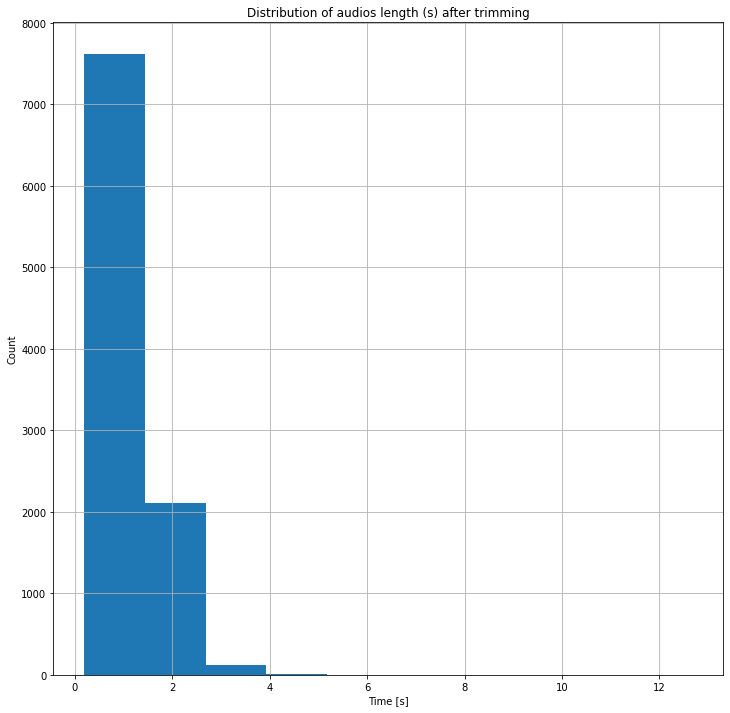

In [22]:
length_audios_trim = []
length_audios_seconds_trim = []
indexes = []
i = 0

for item in df_pd.audio_trim:
    length_audios_trim.append(len(item))
    length_audios_seconds_trim.append(len(item)/sr)
#   Decomment if you are interested in retrieve indexes of audio within a specific range 
    if len(item)/sr  > 4: # se 2.64 prestazioni minori
        indexes.append(i)
    i = i+1
        

length_audios_trim=pd.Series(length_audios_trim)
length_audios_seconds_trim = pd.Series(length_audios_seconds_trim)

#Plot the distribution
plt.figure(figsize=(12,12))
plt.title("Distribution of audios length (s) after trimming")
length_audios_seconds_trim.hist()
plt.xlabel("Time [s]")
plt.ylabel("Count")

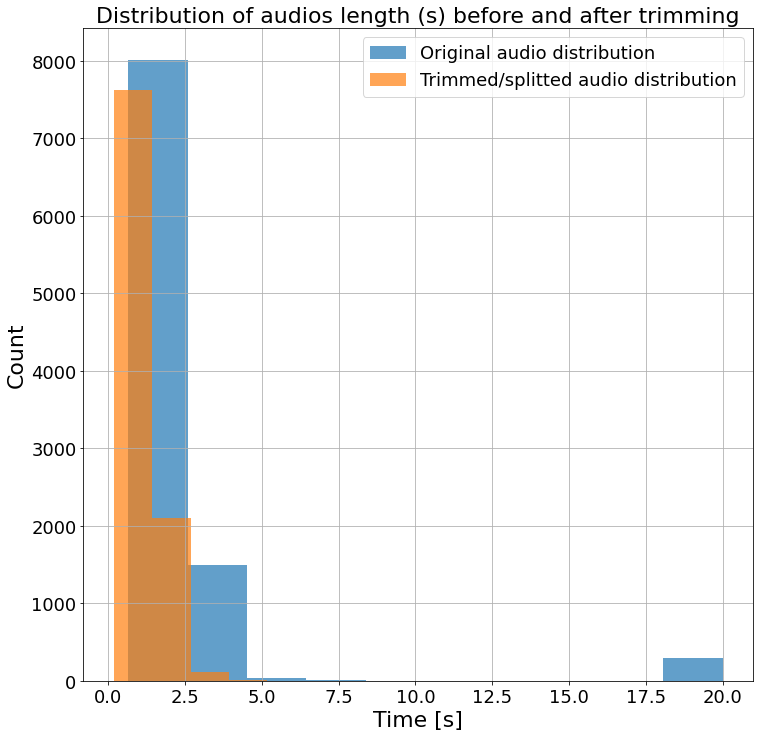

In [23]:
#Plot the distribution
plt.figure(figsize=(12,12))
plt.title("Distribution of audios length (s) before and after trimming", fontsize=22)
length_audios_seconds.hist(alpha = 0.7, label='Original audio distribution', xlabelsize=18)
length_audios_seconds_trim.hist(alpha= 0.7, label='Trimmed/splitted audio distribution', ylabelsize=18)
plt.xlabel("Time [s]", fontsize=22)
plt.ylabel("Count", fontsize=22)
plt.legend(fontsize=18)

# plt.set_xticklabels(x_ticks, rotation=0, fontsize=8)


In [24]:
name_figure = 'audios_distribution.eps'
plt.savefig(path_working_directory + name_figure, format='eps')

<Figure size 432x288 with 0 Axes>

As we can see there are few audios longer than 4 seconds given by the following indexes.

In [25]:
indexes

[25, 75, 569, 620, 2650, 3079, 7123, 7167, 8141, 8230, 8528]

Let's reproduce them to see if they are meaningful or not.

In [26]:
ipd.Audio(df_pd.audio.iloc[8528], rate=22050)

Each of these audios either contains noise or repeated words and since they are really few compared to the oringal dataset size, we decide to drop them to avoid to confuse the model by learning possible features from them that may be misleading.

Since they are very few we consider them as _outliers_ and decide to drop them.

In [27]:
df_pd=df_pd.drop(indexes).reset_index(drop=True) #reset_index because we have a new df and if we want to iterate over it is simpler
df_pd

,Id,audio,gender,ageRange,label,audio_trim
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone,"[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic,"[-7.505116e-05, -7.6106694e-06, 1.10456285e-05..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[0.0005632056, 0.0005720459, 0.00071935874, 0...."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...
9838,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume,"[0.009223618, 0.010777138, 0.009321626, 0.0099..."
9839,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights,"[0.00936052, 0.010867924, 0.009305291, 0.00991..."
9840,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights,"[0.0014334349, 0.001723074, 0.0015384919, 0.00..."
9841,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights,"[0.009742705, 0.011407773, 0.009794228, 0.0103..."


#### 3.2 Split

In [28]:
audios_reconstructed = []

for audio in df_pd.audio_trim:
    
    non_silence_parts = librosa.effects.split(audio, top_db=threshold_VAD)
    audio_reconstructed_parts = [] #save the non silent parts in a list that then will be merged together to obtain the reconstructed file
    
    for part in non_silence_parts:
        audio_reconstructed_parts.append(audio[part[0]:part[-1]])

    audio_reconstructed = np.hstack(audio_reconstructed_parts)
    audios_reconstructed.append(audio_reconstructed)
df_pd['audio_reconstructed'] = audios_reconstructed    
df_pd

,Id,audio,gender,ageRange,label,audio_trim,audio_reconstructed
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone,"[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ...","[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic,"[-7.505116e-05, -7.6106694e-06, 1.10456285e-05...","[-7.505116e-05, -7.6106694e-06, 1.10456285e-05..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[0.0005632056, 0.0005720459, 0.00071935874, 0....","[0.0005632056, 0.0005720459, 0.00071935874, 0...."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...,...
9838,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume,"[0.009223618, 0.010777138, 0.009321626, 0.0099...","[0.009223618, 0.010777138, 0.009321626, 0.0099..."
9839,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights,"[0.00936052, 0.010867924, 0.009305291, 0.00991...","[0.00936052, 0.010867924, 0.009305291, 0.00991..."
9840,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...","[0.0014334349, 0.001723074, 0.0015384919, 0.00..."
9841,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights,"[0.009742705, 0.011407773, 0.009794228, 0.0103...","[0.009742705, 0.011407773, 0.009794228, 0.0103..."


#### 3.3 Dummy Encoding

In [29]:
categorical_features = ['gender', 'ageRange']

dummy_columns = categorical_features

for column in dummy_columns: 
    if column == 'ageRange':
      df_dummies = pd.get_dummies(df_pd[column], prefix = column, prefix_sep='=').drop('ageRange=65+', axis=1)#drop_first_true to avoid multi colinearity problem
    else:
      df_dummies = pd.get_dummies(df_pd[column], drop_first=True, prefix = column, prefix_sep='=') #drop_first_true to avoid multi colinearity problem
      
    df_pd = pd.concat([df_pd, df_dummies], axis = 1)


df_pd = df_pd.drop(columns=dummy_columns)
df_pd

,Id,audio,label,audio_trim,audio_reconstructed,gender=male,ageRange=22-40,ageRange=41-65
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ...","[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ...",0,1,0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[-7.505116e-05, -7.6106694e-06, 1.10456285e-05...","[-7.505116e-05, -7.6106694e-06, 1.10456285e-05...",0,1,0
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...",0,1,0
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[0.0005632056, 0.0005720459, 0.00071935874, 0....","[0.0005632056, 0.0005720459, 0.00071935874, 0....",0,1,0
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...",0,1,0
...,...,...,...,...,...,...,...,...
9838,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",decreasevolume,"[0.009223618, 0.010777138, 0.009321626, 0.0099...","[0.009223618, 0.010777138, 0.009321626, 0.0099...",1,1,0
9839,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",deactivatelights,"[0.00936052, 0.010867924, 0.009305291, 0.00991...","[0.00936052, 0.010867924, 0.009305291, 0.00991...",1,1,0
9840,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",deactivatelights,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...","[0.0014334349, 0.001723074, 0.0015384919, 0.00...",1,1,0
9841,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",deactivatelights,"[0.009742705, 0.011407773, 0.009794228, 0.0103...","[0.009742705, 0.011407773, 0.009794228, 0.0103...",1,1,0



First of all every audio should have the same length in order to get final coefficients for each audio of the same length.


In [30]:
# Find maximum length of the audio in the dataframe
lengths = [len(audio) for audio in df_pd.audio_trim]

lengths = pd.Series(lengths)

# Let's see which is the longest audio we get
print(f"Max length: {lengths.max()} samples = {lengths.max()/sr} seconds")

Max length: 86016 samples = 3.900952380952381 seconds


For the sake of simplicity we take _max_length_ equals to $4$ seconds.

In [31]:
max_length = 4*sr

#### Padding

In [32]:
# # # Padding shorter audio with 0 samples in order to get all audio files of the same length
audios_reconstructed_padded = []
for i, audio in enumerate(df_pd.audio_reconstructed):
    audio_reconstructed_padded = np.pad(df_pd.audio_reconstructed[i],(0,max_length- len(df_pd.audio_reconstructed[i])),mode='constant', constant_values=0)
    audios_reconstructed_padded.append(audio_reconstructed_padded)

df_pd['audio_reconstructed_padded'] = audios_reconstructed_padded  
df_pd  

,Id,audio,label,audio_trim,audio_reconstructed,gender=male,ageRange=22-40,ageRange=41-65,audio_reconstructed_padded
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ...","[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ...",0,1,0,"[-8.641122e-06, 1.5207445e-06, 2.6109909e-05, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[-7.505116e-05, -7.6106694e-06, 1.10456285e-05...","[-7.505116e-05, -7.6106694e-06, 1.10456285e-05...",0,1,0,"[-7.505116e-05, -7.6106694e-06, 1.10456285e-05..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...",0,1,0,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[0.0005632056, 0.0005720459, 0.00071935874, 0....","[0.0005632056, 0.0005720459, 0.00071935874, 0....",0,1,0,"[0.0005632056, 0.0005720459, 0.00071935874, 0...."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...",0,1,0,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...,...,...,...
9838,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",decreasevolume,"[0.009223618, 0.010777138, 0.009321626, 0.0099...","[0.009223618, 0.010777138, 0.009321626, 0.0099...",1,1,0,"[0.009223618, 0.010777138, 0.009321626, 0.0099..."
9839,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",deactivatelights,"[0.00936052, 0.010867924, 0.009305291, 0.00991...","[0.00936052, 0.010867924, 0.009305291, 0.00991...",1,1,0,"[0.00936052, 0.010867924, 0.009305291, 0.00991..."
9840,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",deactivatelights,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...","[0.0014334349, 0.001723074, 0.0015384919, 0.00...",1,1,0,"[0.0014334349, 0.001723074, 0.0015384919, 0.00..."
9841,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",deactivatelights,"[0.009742705, 0.011407773, 0.009794228, 0.0103...","[0.009742705, 0.011407773, 0.009794228, 0.0103...",1,1,0,"[0.009742705, 0.011407773, 0.009794228, 0.0103..."


In [33]:
len(df_pd.audio_reconstructed_padded[3])

88200

Plot any raw audio and its final trimmed, splitted and padded version

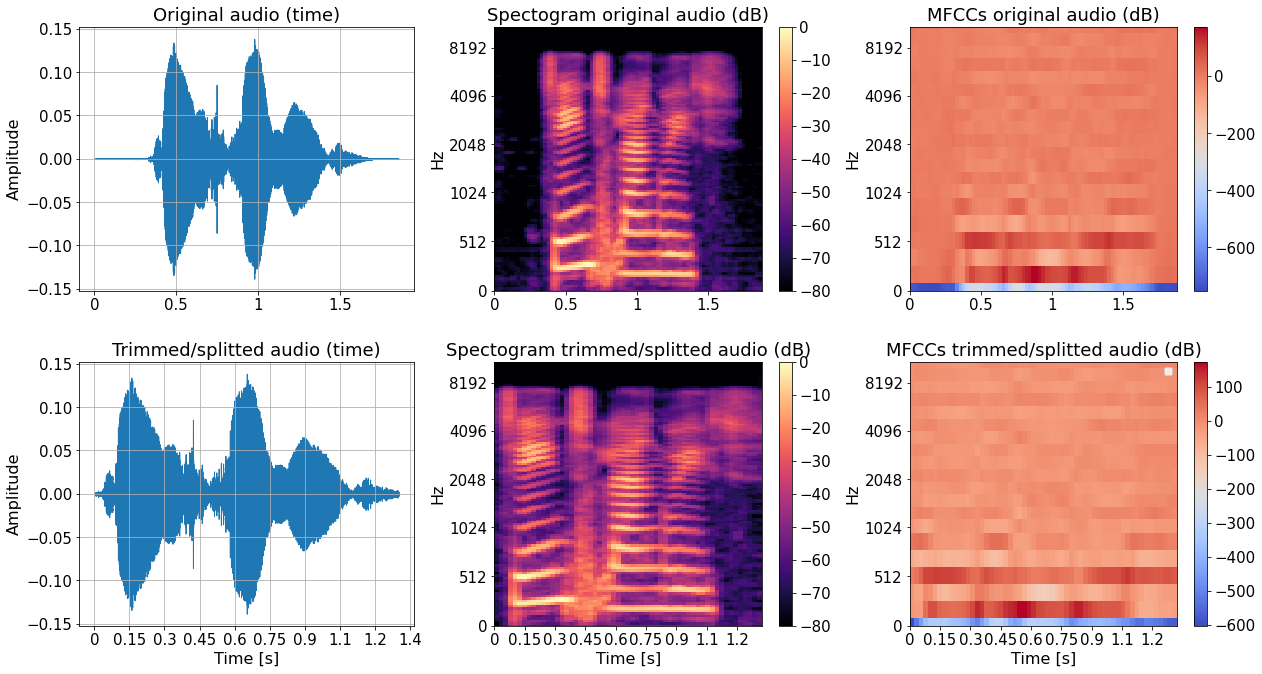

In [34]:
#Compare the original raw audio and the processed one in time and frequency domain

#Original audio in time domain
audio = df_pd.audio[0]
audio_trimmed_splitted = df_pd.audio_reconstructed[0]
audio_trimmed_splitted_padded = df_pd.audio_reconstructed_padded[0]

#Original audio in frequency domain and MFCC
mel_features_audio = librosa.feature.melspectrogram(y=audio, sr=sr)
mfcc_audio  = librosa.feature.mfcc(y=audio, sr=sr)

#Trimmed/splitted audio in frequency domain
mel_features_audio_trimmed_splitted = librosa.feature.melspectrogram(y=audio_trimmed_splitted, sr=sr)
mfcc_audio_trimmed_splitted = librosa.feature.mfcc(y=audio_trimmed_splitted, sr=sr)

#Converting mel spectogram in dB scale
S1 = librosa.power_to_db(mel_features_audio, ref=np.max)
S2 = librosa.power_to_db(mel_features_audio_trimmed_splitted, ref=np.max)


#Plot the audios in time and corresponding spectrograms
fig, axs = plt.subplots(2,3, figsize=(18,10))
fig.tight_layout(pad=5.0)


#Plot original audio
img_original = librosa.display.waveshow(audio,sr=sr, x_axis='time', label='original', ax=axs[0,0]);
img_original_mel = librosa.display.specshow(S1, x_axis='time', y_axis='mel', ax=axs[0, 1]) # mfcc in row i, column 1
img_original_mfcc = librosa.display.specshow(mfcc_audio, x_axis='time', y_axis='mel',ax=axs[0,2])

#Plot trimmed/splitted audio
img_trimmed_splitted = librosa.display.waveshow(audio_trimmed_splitted,sr=sr, x_axis='time', label='processed', ax=axs[1,0]);
img_trimmed_splitted_mel = librosa.display.specshow(S2, x_axis='time', y_axis='mel', ax=axs[1, 1]) # mfcc in row i, column 1
img_trimmed_splitted_mfcc = librosa.display.specshow(mfcc_audio_trimmed_splitted, x_axis='time',y_axis='mel', ax=axs[1,2])

# SETTING FONTSIZE OF TITLES, LABELS AND VALUES OF LABELS

#First row of subplots (original audio)
title_font_size = 18
label_font_size = title_font_size-2
label_values_font_size = title_font_size-3

axs[0,0].set_title("Original audio (time)", size=title_font_size)
axs[0,0].set_ylabel("Amplitude", size=label_font_size)
axs[0,0].tick_params(axis='x', labelsize=label_values_font_size)
axs[0,0].tick_params(axis='y', labelsize=label_values_font_size)
axs[0,0].grid()

axs[0,1].set_title("Spectogram original audio (dB)", size=title_font_size)
axs[0,1].set_ylabel("Hz", size=label_font_size)
axs[0,1].tick_params(axis='x', labelsize=label_values_font_size)
axs[0,1].tick_params(axis='y', labelsize=label_values_font_size)

axs[0,2].set_title("MFCCs original audio (dB)" , size=title_font_size)
axs[0,2].set_ylabel("Hz", size=label_font_size)
axs[0,2].tick_params(axis='x', labelsize=label_values_font_size)
axs[0,2].tick_params(axis='y', labelsize=label_values_font_size)


#Second row of subplots (trimmed/splitted audio)
axs[1,0].set_title("Trimmed/splitted audio (time)", size=title_font_size)
axs[1,0].set_ylabel("Amplitude", size=label_font_size)
axs[1,0].set_xlabel("Time [s]", size=label_font_size)
axs[1,0].tick_params(axis='x', labelsize=label_values_font_size)
axs[1,0].tick_params(axis='y', labelsize=label_values_font_size)
axs[1,0].grid()

axs[1,1].set_title("Spectogram trimmed/splitted audio (dB)", size=title_font_size)
axs[1,1].set_ylabel("Hz", size=label_font_size)
axs[1,1].set_xlabel("Time [s]", size=label_font_size)
axs[1,1].tick_params(axis='x', labelsize=label_values_font_size)
axs[1,1].tick_params(axis='y', labelsize=label_values_font_size)

axs[1,2].set_title("MFCCs trimmed/splitted audio (dB)" , size=title_font_size)
axs[1,2].set_ylabel("Hz", size=label_font_size)
axs[1,2].set_xlabel("Time [s]", size=label_font_size)
axs[1,2].tick_params(axis='x', labelsize=label_values_font_size)
axs[1,2].tick_params(axis='y', labelsize=label_values_font_size)

# Adding colorbars for spectrograms legend
fig.colorbar(img_original_mel, ax=[axs[0,1]]).ax.tick_params(labelsize=15)
fig.colorbar(img_original_mfcc, ax=[axs[0,2]]).ax.tick_params(labelsize=15)
fig.colorbar(img_trimmed_splitted_mel, ax=[axs[1,1]]).ax.tick_params(labelsize=15)
fig.colorbar(img_trimmed_splitted_mfcc, ax=[axs[1,2]]).ax.tick_params(labelsize=15)



plt.legend()


#Hide x label text of first row for better readability
axs[0,0].axes.get_xaxis().get_label().set_visible(False)
axs[0,1].axes.get_xaxis().get_label().set_visible(False)
axs[0,2].axes.get_xaxis().get_label().set_visible(False)

In [35]:
name_figure = 'audio_preprocessed.eps'
plt.savefig(path_working_directory + name_figure, format='eps')


<Figure size 432x288 with 0 Axes>

## 4. Training

The models used for this project are Random Forest and SVM classifiers.

### 4.1 Feature Extraction


Generate a feature matrix on which classifiers will be trained on.

Here are presented $2$ different ways to convert the MFCC spectrogram extracted through a flag variable _split_in_matrices_:

**1. Coefficients aggregation (_split_in_matrices_ = False)**: we compute the mean, standard deviation, median, min and max for each coefficient of the MFCC spectogram extracted. Then we horizontally stack together these statistics to get the final feature vector.

**2. Subdivision in chunks plus aggregation (_split_in_matrices_ = True)**: audios padded generate all MFCC spectrograms of the same shape $(R, C)$. $R$ is equal to the number of MFCC coefficients extracted while $C$ depends on the audio length, thus will be the same for every audio since they all have been padded. Then we split each MFCC spectrogram into $nr = R$ rows and $nc$ columns to get $n_r * n_c$ submatrices in total. For each submatrix, mean and standard deviation are computed and horizontally stack together to get the final row feature vector for each audio.

In [36]:
seed = 42 #set a seed for reproducibility of results


In [37]:
def split_submatrices (matrix, nr, nc):    
    means = []
    stds = []
    
    R = matrix.shape[0]
    C = matrix.shape[1]
    
    width_row =  R//nr 
    width_col = C//nc

    # Define the original matrix 
    original_matrix = matrix

    # Divide the original matrix into submatrices 
    submatrices = np.array([original_matrix[i:i+width_row, j:j+width_col] for i in range(0, original_matrix.shape[0], width_row) for j in range(0, original_matrix.shape[1], width_col)]) 

    for sub in submatrices:
        means.append(sub.mean())
        stds.append(sub.std())
    
    row_to_add = means + stds
    return row_to_add

In [38]:
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler_training = StandardScaler()

features = []
hop_length = 128
frame_rate = sr*2/hop_length

n_ffts = [512, 1024, 2048, 4096, 8192]
hops = [64, 128, 256, 512, 1024, 2048, 4096]


svm = True



features = []
for i, audio in enumerate(df_pd.audio_reconstructed_padded):

    #For each padded audio we extract MFCC 
    mfcc_features = librosa.feature.mfcc(y=audio, 
                              sr=sr*2, 
                              n_fft=2048, 
                              hop_length=128,
                              n_mfcc=13,
                              n_mels=40)


    #Converting MFCC into row feature vector:For each coefficient we compute the mean, median, std, max, min so we will have a total of n_mfcc*5 features for each audio
    #print(mfcc_features.shape)
    if split_in_matrices == True:
      audio_features = split_submatrices(mfcc_features, 13, nc)
    else: 
        mfcc_means = mfcc_features.mean(axis=1)
        mfcc_medians = np.median(mfcc_features, axis=1)
        mfcc_stds = mfcc_features.std(axis=1)
        mfcc_maxs = mfcc_features.max(axis=1)
        mfcc_mins = mfcc_features.min(axis=1)

        #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
        audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)

    features.append(audio_features)

    
Xf = pd.DataFrame(features)
Xf       

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-375.503235,13.738831,-8.138162,7.460486,-12.641273,4.478424,-4.277375,-0.284106,-5.792784,-0.757288,...,-3.667954,-61.843887,-17.032871,-36.205826,-20.444435,-32.050301,-23.260956,-34.155060,-20.553261,-20.918085
1,-422.965485,14.353173,-2.201381,2.612468,-3.793124,0.525777,-2.702622,0.224551,-3.486351,-0.700025,...,-20.426373,-49.784809,-23.515362,-39.061100,-23.496700,-34.362366,-16.727554,-26.282433,-21.310387,-26.546885
2,-446.349487,28.695179,-8.394278,0.697131,-2.044577,-0.603376,-4.321205,3.653518,-4.428420,-2.021499,...,-46.259346,-30.842297,-26.653654,-31.888321,-4.731544,-33.970116,-21.997349,-25.805683,-14.777038,-18.614468
3,-369.012329,18.397291,-10.629284,1.922958,-4.155220,1.389265,-2.785237,-1.406129,-1.228959,-2.365011,...,-15.578780,-44.500099,-22.388807,-26.639652,-23.950935,-15.887344,-30.654007,-25.103996,-25.772867,-27.379692
4,-419.516815,36.287827,-7.478950,-3.586302,1.886703,-2.156051,-3.047281,0.028499,-3.429040,-4.532731,...,-37.139771,-20.857544,-30.856722,-22.895115,-8.230634,-22.017452,-31.281652,-17.614790,-11.776514,-20.143429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838,-308.841766,35.675270,-5.871049,6.768967,-5.410623,4.392212,0.001018,-1.608168,-0.883074,-0.091333,...,-17.556114,-53.462509,-14.910682,-17.128313,-20.673313,-25.302048,-13.165585,-18.352406,-12.337572,-14.329849
9839,-323.407776,24.257881,-6.985923,6.736770,-8.879407,7.569347,-1.067541,0.719635,0.540365,1.722153,...,-23.952240,-47.355236,-9.448762,-27.251448,-26.950447,-15.758943,-14.727023,-23.299583,-11.742405,-13.910120
9840,-304.604767,30.037731,-11.221449,7.044686,-6.579359,7.570440,-0.718871,1.195073,0.060385,1.602293,...,-27.476871,-47.062576,-11.500645,-35.417587,-18.149006,-14.249207,-11.388174,-24.820110,-9.962939,-15.119090
9841,-336.906738,19.041216,-4.880103,5.489252,-4.630620,5.977491,-0.478405,0.767844,0.255227,1.058990,...,-11.998741,-59.378410,-4.993690,-37.174118,-21.992529,-16.455254,-6.253464,-20.051434,-16.635113,-14.279949


### 4.2 Train test split

In [39]:
X = Xf
y = df_pd["label"]
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indices_train, indices_test= train_test_split(X, y, indices, test_size=0.2, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7874, 65) (1969, 65) (7874,) (1969,)


### 4.3 Standardization
Pay attention: the standardization has to be made by first fitting on training data and then transform X_train and X_test with standard scaler fit on the training data.

In [40]:
def standardize_feature_matrix_stack_categorical_features(X_feature_matrix, df_pd, sc, indeces, ifTrain=True):
  
  if ifTrain == True:
    sc.fit(X_feature_matrix)
  X_feature_matrix_standardized = sc.transform(X_feature_matrix)
  X_feature_matrix_standardized = pd.DataFrame(X_feature_matrix_standardized).set_index(indeces)

  #Stack OHE columns
  X_categorical = df_pd.loc[indeces, ['gender=male', 'ageRange=22-40', 'ageRange=41-65']]
  X_feature_matrix_new = pd.concat([X_categorical, X_feature_matrix_standardized], axis=1)
  return X_feature_matrix_new, sc

X_train_std, sc_training = standardize_feature_matrix_stack_categorical_features(X_train, df_pd, StandardScaler(), indices_train, ifTrain=True)

In [41]:
X_train_std

,gender=male,ageRange=22-40,ageRange=41-65,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
5798,0,1,0,-1.682313,-1.122946,1.247222,-0.137822,0.822132,0.388420,0.460678,...,1.465024,0.650660,0.102002,-0.032836,1.592333,1.209810,-0.072524,1.669172,1.222941,0.563507
625,1,1,0,-0.329114,0.050491,0.596141,0.697174,1.171122,-0.029015,0.568407,...,0.930553,1.495236,-0.261064,0.503856,0.663999,0.385967,0.372998,1.417355,1.229115,0.916820
1922,1,1,0,-0.256652,-0.511393,0.718789,-0.518702,1.046254,0.586013,1.106682,...,-0.332421,1.143595,0.117527,0.675638,1.230729,0.818614,-1.080307,-0.195542,-0.719682,-0.365824
6876,1,1,0,-0.481660,-0.755630,0.559898,0.241318,0.445852,-0.988120,0.479847,...,0.182582,0.281881,-1.106964,0.839308,1.167216,0.074332,1.611689,-0.526658,0.562595,0.375156
9671,0,1,0,0.646970,-0.999506,-0.676713,0.117105,-0.679231,-0.132601,-1.636931,...,1.010607,-0.643782,0.436456,-1.773699,0.836456,1.259615,-0.532739,-0.686684,0.353675,0.522133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,1,0,-0.405825,-0.407503,0.002021,-0.194853,0.368333,1.236308,-0.288535,...,0.852113,-0.004049,1.373425,0.272205,2.121814,0.964896,-0.551343,1.113256,1.284669,0.588726
5191,0,1,0,0.787980,0.006407,-0.474186,-0.087031,-0.252538,0.583370,-0.650455,...,-0.831171,0.646195,-0.578451,0.094980,0.281992,0.061034,1.314301,0.539732,0.508214,0.378119
5390,1,1,0,-0.426580,-0.570845,0.583195,0.796133,-0.113085,-1.093161,0.433166,...,1.465024,-0.617709,-1.019202,-0.747456,0.560196,-0.170297,0.490737,0.236340,1.280972,0.004728
860,1,0,1,-0.063965,-0.121492,1.324115,0.115950,0.469934,0.457324,0.887439,...,1.148032,0.267565,1.030505,0.622916,1.140038,-0.735379,1.636000,0.447448,2.065102,1.562641


In [42]:
X_test_std, _ = standardize_feature_matrix_stack_categorical_features(X_test, df_pd, sc_training, indices_test, ifTrain=False)
X_test_std

,gender=male,ageRange=22-40,ageRange=41-65,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
4618,1,0,1,-0.041625,-1.873519,0.426411,1.307528,-0.454888,1.848624,-1.105438,...,1.191090,-0.236509,1.228349,-0.908374,1.882478,-1.034103,2.240696,-0.624576,1.887408,0.970508
7122,1,1,0,-2.009383,0.376165,0.905832,-0.598356,-0.034140,0.961320,0.173841,...,0.181889,0.032250,2.107157,-0.163048,2.121814,0.071865,1.188085,0.723968,0.840966,1.210457
106,0,1,0,0.067365,0.361915,0.937835,-0.637148,1.203773,-0.466064,-0.365347,...,-1.147015,0.290298,-0.938353,-0.279464,-1.098369,0.906363,0.830916,0.421230,-2.362578,-0.902534
1543,0,1,0,-0.024664,-1.076667,0.038556,0.389603,-0.578764,0.793037,-1.340614,...,1.048661,-0.961924,1.238842,-1.627575,-2.049167,-0.068568,-1.865355,1.145875,-0.644331,0.041145
4464,1,1,0,0.159263,0.105927,0.191031,0.749378,-0.545777,-0.127039,0.335398,...,1.465024,-0.901162,0.610221,0.624019,0.583830,-0.519915,-0.689606,1.566008,-0.363983,-0.282008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957,1,1,0,-0.171522,0.367804,-0.379030,-0.050782,1.002630,0.178524,-0.550138,...,0.227998,0.099721,-0.600808,-0.286609,0.536242,0.983782,-1.244519,0.310008,0.781575,0.436498
1452,1,1,0,0.154174,2.352950,-2.379810,0.014934,1.850986,-2.085625,0.409252,...,0.801680,1.618340,-2.135818,0.966271,-1.135033,0.558622,-0.116201,-0.364032,0.264104,0.139930
101,0,1,0,-1.786192,-0.847710,-0.411457,1.284186,-1.846679,2.841654,-1.339783,...,0.416767,-0.748785,1.716443,-0.790499,-0.432637,-1.600497,-1.076426,-1.440608,-1.146956,-1.155163
319,0,0,1,0.553119,0.604499,0.292355,-0.304776,0.215742,0.053939,0.162374,...,0.340208,0.694619,0.429502,-0.379815,-0.686211,-0.333930,0.839953,-1.344205,0.756571,0.114023


### 4.5  K - Cross Validation
Apply k-cross validation on classifiers parameters with $k = 10$.
We use a custom k cross validation function because we want to standardize the fold used for validation with $\mu$ and $\sigma$ derived from the $k-1$ folds used for training.

In [43]:
#function to retrieve params to evaluate during grid search

def retrieve_params_model(model_name):
  

  if model_name == 'SVM':
    # define SVM params
    param1 = ['poly', 'rbf', 'sigmoid']               #krnels
    param2 =   ['scale']                              #gamma
    param3 = [10, 13, 15]                             #C

    model = SVC(random_state = seed)

  else: #RF
    param1 = [100, 150, 200]                          #n_estimators
    param2 = ['sqrt', 'log2']                         #max_features
    param3 = ['gini', 'entropy']
    model = RandomForestClassifier(random_state = seed)


  return param1, param2, param3, model

In [44]:
def return_train_val_datasets(idx_start_val, idx_stop_val, X_train, y_train, exit = False):
# """
# Inputs: 

# - idx_start_val: index of the first element of the current validation dataset
# - idx_stop_val: index of the last element of the current validation dataset
# - X_train: 80% of original dataset (without class label)
# - y_train: 80% of original class label

# Returns:

# - X_train_train: the training dataset at iteration i (9/10 of X_train)
# - X_val_train: the validation dataset at iteration i (1/10 of X_train)
# - y_train_train: the training class label at iteration i (9/10 of y_train)
# - y_val_train: the validation class label at iteration i (1/10 of y_train)
# """  

  X_val_train = X_train.iloc[idx_start_val:idx_stop_val]
  y_val_train = y_train.iloc[idx_start_val:idx_stop_val]

  #print(X_val_train.shape)
  X_train_train_sx = X_train.iloc[0:idx_start_val]
  X_train_train_dx = X_train.iloc[idx_stop_val: n_samples_training-1]
  #print(X_train_train_sx.shape, X_train_train_dx.shape, idx_start_val, idx_stop_val)
  y_train_train_sx = y_train.iloc[0:idx_start_val]
  y_train_train_dx = y_train.iloc[idx_stop_val: n_samples_training-1]


  #Concat the training dataframe at the left of validation dataset with the one on the right
  #to obtain a unique training dataset to use to fit the classifier
  X_train_train = pd.concat([X_train_train_sx, X_train_train_dx], axis=0)
  y_train_train = pd.concat([y_train_train_sx, y_train_train_dx], axis=0)

  return X_train_train, X_val_train, y_train_train, y_val_train

In [45]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# PREPARING DATA STRUCTURE WHERE TO STORE THE RESULTS OF MODELS
models = {}
models = {
          'SVM': SVC(random_state=seed),
          'RF': RandomForestClassifier(random_state=seed)}

models_names = [ 'SVM', 'RF']
hyperparams = {}

# define SVM params
kernels = ['poly', 'rbf', 'sigmoid']
C = [10, 13, 15]
gammas = ['scale']

# # define grid search RF
n_estimators = [100, 150, 200]
max_features = ['sqrt', 'log2']
criterions = ['gini', 'entropy']

for name in models_names:
  models[name] = {}



  if name == 'SVM':

    #models[dataset][name]['model'] = SVC()
    models[name]['bestParams'] = {}

    for kernel in kernels:
        models[name][kernel] = {}

        for gamma in gammas:
          models[name][kernel][gamma] = {}
          
          for c in C:
            models[name][kernel][gamma][c]  ={}

  else:
    #models[name] = {'model': RandomForestClassifier()}
    models[name]['bestParams'] = {}

    for estimator in n_estimators:
      models[name][estimator] = {}

      for feature in max_features:
        models[name][estimator][feature] = {}   

        for criterion in criterions:
          models[name][estimator][feature][criterion] = {}     

In [46]:
from sklearn.metrics import classification_report

#K-Cross Validation
model_name = 'RF'
params1, params2, params3, model = retrieve_params_model(model_name)
k=10
n_samples_training = X_train.shape[0]
n_samples_val = n_samples_training//k
idx_start_val = 0
idx_stop_val = n_samples_val-1
i=0

best_accuracy = 0
for model_name in ['SVM', 'RF']:
  best_accuracy = 0
  params1, params2, params3, model = retrieve_params_model(model_name)
  for param1 in params1:
    for param2 in params2:
      for param3 in params3:

        if model_name == 'SVM':
            model = SVC(kernel=param1, gamma=param2, C=param3)
          
        else:
            model = RandomForestClassifier(n_estimators=param1, max_features=param2, criterion=param3)

        print(param1, param2, param3)
        print("")
        idx_start_val = 0
        idx_stop_val = n_samples_val-1
        i=0

        sum_accuracy = 0


        for i in range(k): #10 total iterations for each combination of hyperparams
          #print(i)

          #Checking if the last fold is a multiple of n_samples_val, if not we set the last element of the validation dataset to 
          #the last element of X_train so the last validation dataset will be a bit longer 
          if X_train.iloc[idx_stop_val:n_samples_training-1].shape[0] < n_samples_val or idx_start_val > idx_stop_val:
            idx_stop_val = n_samples_training-1

          if idx_start_val < idx_stop_val:
            sc_cv = StandardScaler()
            X_train_train, X_val_train, y_train_train, y_val_train = return_train_val_datasets(idx_start_val, idx_stop_val, X_train, y_train)
            
            X_train_train_std, sc_train_train = standardize_feature_matrix_stack_categorical_features(X_train_train, df_pd, StandardScaler(), X_train_train.index, ifTrain=True)
            X_val_train_std, _24 = standardize_feature_matrix_stack_categorical_features(X_val_train, df_pd, sc_train_train, X_val_train.index, ifTrain=False)

          else:
            break
          #print(y_val_train.value_counts())
          idx_start_val = idx_stop_val+1
          idx_stop_val = idx_stop_val + n_samples_val

          #Original scenario
          
          #print("original")
          model = model.fit(X_train_train_std, y_train_train)
            
          #Validation on current fold
          y_pred_val = model.predict(X_val_train_std)

          #Print the results and store the results obtained
          cr = classification_report(y_pred_val, y_val_train, output_dict=True)
          #print(cr['accuracy'])
          #print(cr)
          #print("")

          
          models[model_name][param1][param2][param3] =cr

          sum_accuracy = sum_accuracy + cr['accuracy']

        #Compute the mean of the results after the 10 iterations of a specific
        #combination of hyperparameters are completed and see if outperforms the
        #results reached for a different combination seen before.
        mean_accuracy = sum_accuracy/k
        #print(mean_accuracy)

        #Store best weighted accuracy and the current hyperparams 
        if( mean_accuracy > best_accuracy):
          best_accuracy = mean_accuracy
          print(f"Best accuracy: {best_accuracy:.3f}")
          print(f"Best params: {param1, param2, param3}")
          models[model_name]['best_accuracy'] = best_accuracy
          models[model_name]['bestParams'] = {param1, param2, param3}






poly scale 10

Best accuracy: 0.579
Best params: ('poly', 'scale', 10)
poly scale 13

Best accuracy: 0.580
Best params: ('poly', 'scale', 13)
poly scale 15

rbf scale 10

Best accuracy: 0.624
Best params: ('rbf', 'scale', 10)
rbf scale 13

Best accuracy: 0.627
Best params: ('rbf', 'scale', 13)
rbf scale 15

Best accuracy: 0.628
Best params: ('rbf', 'scale', 15)
sigmoid scale 10

sigmoid scale 13

sigmoid scale 15

100 sqrt gini

Best accuracy: 0.508
Best params: (100, 'sqrt', 'gini')
100 sqrt entropy

Best accuracy: 0.511
Best params: (100, 'sqrt', 'entropy')
100 log2 gini

Best accuracy: 0.511
Best params: (100, 'log2', 'gini')
100 log2 entropy

150 sqrt gini

Best accuracy: 0.521
Best params: (150, 'sqrt', 'gini')
150 sqrt entropy

150 log2 gini

150 log2 entropy

200 sqrt gini

200 sqrt entropy

Best accuracy: 0.522
Best params: (200, 'sqrt', 'entropy')
200 log2 gini

200 log2 entropy



In [47]:
models['RF']['bestParams'], models['RF']['best_accuracy']

({200, 'entropy', 'sqrt'}, 0.5222691403356202)

In [48]:
models['SVM']['bestParams'], models['SVM']['best_accuracy']

({15, 'rbf', 'scale'}, 0.6275514542467872)

In [49]:
best_model_SVM = SVC(random_state=seed, C=15, gamma='scale', kernel='rbf') 
best_model_RF = RandomForestClassifier(random_state=seed, criterion='entropy', max_features='sqrt', n_estimators=200)

best_model_SVM.fit(X_train_std, y_train)
best_model_RF.fit(X_train_std, y_train)

y_pred_SVM = best_model_SVM.predict(X_test_std)
y_pred_RF = best_model_RF.predict(X_test_std)

In [50]:
from sklearn.metrics import accuracy_score
print(f"Test accuracy SVM: {accuracy_score(y_pred_SVM, y_test)}")
print(f"Test accuracy RF: {accuracy_score(y_pred_RF, y_test)}")

Test accuracy SVM: 0.6241747079735906
Test accuracy RF: 0.5088877602844083


### FIt on entire development set

In [51]:
X

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-375.503235,13.738831,-8.138162,7.460486,-12.641273,4.478424,-4.277375,-0.284106,-5.792784,-0.757288,...,-3.667954,-61.843887,-17.032871,-36.205826,-20.444435,-32.050301,-23.260956,-34.155060,-20.553261,-20.918085
1,-422.965485,14.353173,-2.201381,2.612468,-3.793124,0.525777,-2.702622,0.224551,-3.486351,-0.700025,...,-20.426373,-49.784809,-23.515362,-39.061100,-23.496700,-34.362366,-16.727554,-26.282433,-21.310387,-26.546885
2,-446.349487,28.695179,-8.394278,0.697131,-2.044577,-0.603376,-4.321205,3.653518,-4.428420,-2.021499,...,-46.259346,-30.842297,-26.653654,-31.888321,-4.731544,-33.970116,-21.997349,-25.805683,-14.777038,-18.614468
3,-369.012329,18.397291,-10.629284,1.922958,-4.155220,1.389265,-2.785237,-1.406129,-1.228959,-2.365011,...,-15.578780,-44.500099,-22.388807,-26.639652,-23.950935,-15.887344,-30.654007,-25.103996,-25.772867,-27.379692
4,-419.516815,36.287827,-7.478950,-3.586302,1.886703,-2.156051,-3.047281,0.028499,-3.429040,-4.532731,...,-37.139771,-20.857544,-30.856722,-22.895115,-8.230634,-22.017452,-31.281652,-17.614790,-11.776514,-20.143429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838,-308.841766,35.675270,-5.871049,6.768967,-5.410623,4.392212,0.001018,-1.608168,-0.883074,-0.091333,...,-17.556114,-53.462509,-14.910682,-17.128313,-20.673313,-25.302048,-13.165585,-18.352406,-12.337572,-14.329849
9839,-323.407776,24.257881,-6.985923,6.736770,-8.879407,7.569347,-1.067541,0.719635,0.540365,1.722153,...,-23.952240,-47.355236,-9.448762,-27.251448,-26.950447,-15.758943,-14.727023,-23.299583,-11.742405,-13.910120
9840,-304.604767,30.037731,-11.221449,7.044686,-6.579359,7.570440,-0.718871,1.195073,0.060385,1.602293,...,-27.476871,-47.062576,-11.500645,-35.417587,-18.149006,-14.249207,-11.388174,-24.820110,-9.962939,-15.119090
9841,-336.906738,19.041216,-4.880103,5.489252,-4.630620,5.977491,-0.478405,0.767844,0.255227,1.058990,...,-11.998741,-59.378410,-4.993690,-37.174118,-21.992529,-16.455254,-6.253464,-20.051434,-16.635113,-14.279949


In [52]:
X_dev, sc_dev = standardize_feature_matrix_stack_categorical_features(X, df_pd, StandardScaler(), df_pd.index, ifTrain=True)

In [53]:
X_dev

,gender=male,ageRange=22-40,ageRange=41-65,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
0,0,1,0,-1.963168,-0.896278,-0.149332,0.894681,-1.356933,1.684912,-0.178035,...,1.199145,-0.667227,0.936045,-0.213583,-0.130226,-0.500289,-0.586461,-1.801094,-0.351921,-0.382644
1,0,1,0,-3.282242,-0.833100,1.032167,-0.325095,0.733204,0.446059,0.359014,...,0.003388,0.142086,0.395678,-0.487146,-0.463834,-0.774805,0.211592,-0.539277,-0.474813,-1.350168
2,0,1,0,-3.932131,0.641809,-0.200303,-0.807000,1.146251,0.092156,-0.192983,...,-1.839863,1.413364,0.134077,0.200076,1.587172,-0.728232,-0.432111,-0.462864,0.585643,0.013320
3,0,1,0,-1.782772,-0.417209,-0.645099,-0.498578,0.647669,0.716697,0.330839,...,0.349276,0.496756,0.489585,0.702949,-0.513481,1.418769,-1.489520,-0.350398,-1.199137,-1.493317
4,0,1,0,-3.186396,1.422624,-0.018140,-1.884725,2.074910,-0.394489,0.241472,...,-1.189157,2.083464,-0.216282,1.061712,1.204726,0.690930,-1.566186,0.849965,1.072671,-0.249490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838,1,1,0,-0.110509,1.359630,0.301854,0.720693,0.351113,1.657891,1.281055,...,0.208188,-0.104733,1.112947,1.614227,-0.155242,0.300944,0.646686,0.731741,0.981603,0.749794
9839,1,1,0,-0.515328,0.185484,0.079979,0.712592,-0.468293,2.653681,0.916637,...,-0.248192,0.305141,1.568241,0.644333,-0.841324,1.434015,0.455957,-0.061188,1.078207,0.821941
9840,1,1,0,0.007246,0.779875,-0.762947,0.790065,0.075031,2.654023,1.035546,...,-0.499684,0.324782,1.397200,-0.138062,0.120662,1.613268,0.863796,-0.304897,1.367040,0.614133
9841,1,1,0,-0.890492,-0.350989,0.499065,0.398713,0.535368,2.154755,1.117554,...,0.604721,-0.501763,1.939607,-0.306355,-0.299430,1.351340,1.490999,0.459422,0.284051,0.758371


In [54]:
final_best_model_SVM = SVC(random_state=seed, C=15, gamma='scale', kernel='rbf') 
final_best_model_RF = RandomForestClassifier(random_state=seed, criterion='entropy', max_features='sqrt', n_estimators=200)

final_best_model_SVM.fit(X_dev, y)
final_best_model_RF.fit(X_dev, y)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=200, random_state=42)

## 5. Testing on Evaluation set

In [55]:
colab = True

if colab == True:
  path= r'/content/evaluation.csv'
else:
  path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'

df_evaluation = pd.read_csv(path)
df_evaluation

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
2,2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65
3,3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
4,4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65
...,...,...,...,...,...,...,...,...
1450,1450,dsl_data/audio/speakers/oOK5kxoW7dskMbaK/02f5d...,oOK5kxoW7dskMbaK,native,English (United States),English (United States),female,22-40
1451,1451,dsl_data/audio/speakers/oOK5kxoW7dskMbaK/87191...,oOK5kxoW7dskMbaK,native,English (United States),English (United States),female,22-40
1452,1452,dsl_data/audio/speakers/ppymZZDb2Bf4NQnE/f2a9e...,ppymZZDb2Bf4NQnE,native,English (United States),English (United States),female,41-65
1453,1453,dsl_data/audio/speakers/aokxBz9LxXHzZzay/f347b...,aokxBz9LxXHzZzay,native,English (United States),English (United States),female,22-40


In [56]:
if colab == True:
  path_working_directory= r'/content/drive/MyDrive/'
else:
  path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_evaluation['path']

In [57]:
# signals = []
# ids = []
# genders = []
# ageRanges = []

# for i, row in df_evaluation.iterrows():
#     path = row['path']
#     gender = row['gender']
#     ageRange = row['ageRange']

#     file_path = f'{path_working_directory}/{path}'
#     print(file_path)
#     signal, sr = librosa.load(file_path)

#     ids.append(i)
#     signals.append(signal)
#     genders.append(gender)
#     ageRanges.append(ageRange)



# for path in paths_recordings_dev:
#     file_path = f'{path_to_load_dev}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)


In [58]:
# df_pd_eval = pd.DataFrame()
# df_pd_eval['Id'] = ids
# df_pd_eval['audio'] = signals
# df_pd_eval['gender'] = genders
# df_pd_eval['ageRange'] = ageRanges
# df_pd_eval

# df.append(path_recording_eval)
# df_eval.append(signals)
# df_eval.append(sample_rates)
# #df_eval.append(labels)

In [59]:
path_working_directory

'/content/drive/MyDrive/'

In [60]:
# name_file = r'/df_pd_eval.pickle'
# print( path_working_directory+name_file)
# with open(path_working_directory+name_file, "wb") as output_file:
#     pickle.dump(df_pd_eval, output_file)

In [61]:
# if colab == True:
#   path_working_directory= r'/content/drive/MyDrive/'
# else:
#   path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
# paths_recordings = df_evaluation['path']

In [62]:
# signals = []
# sample_rates = []

# for path in paths_recordings:
#     file_path = f'{path_working_directory}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)
#     sample_rates.append(sr)

In [63]:
# df_eval = []
# df_eval.append(paths_recordings)
# df_eval.append(signals)
# df_eval.append(sample_rates)
# #df_eval.append(labels)

### Load _df_eval_ pickle file.

In [64]:
name_file = r'/df_pd_eval.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df_pd_eval = pickle.load(f)
df_pd_eval

,Id,audio,gender,ageRange
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65
...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40


### Trim

In [65]:
trim_audios = []
for i, audio in enumerate(df_pd_eval.audio):
    audio_trim = librosa.effects.trim(audio, top_db=threshold_VAD)[0]
    trim_audios.append(audio_trim)
    
df_pd_eval['audio_trim'] = trim_audios    
df_pd_eval

,Id,audio,gender,ageRange,audio_trim
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-9.9547375e-05, -9.787871e-05, -6.138714e-05,..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[4.1767595e-05, 4.2155876e-05, 0.00010558358, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[0.0006176711, 0.00032735444, 0.00043957832, 0..."
...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[0.00013520455, 0.00038343164, 0.00084033713, ..."
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.00037428836, -0.00066498155, -0.0004639936..."
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.0036772517, 0.0010779247, 0.00663003, 0.00..."
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.0011414234, -0.0012965349, -0.0014081917, ..."


### Split

In [66]:
audios_reconstructed = []

for audio in df_pd_eval.audio_trim:
    
    non_silence_parts = librosa.effects.split(audio, top_db=threshold_VAD)
    audio_reconstructed_parts = [] #save the non silent parts in a list that then will be merged together to obtain the reconstructed file
    
    for part in non_silence_parts:
        audio_reconstructed_parts.append(audio[part[0]:part[-1]])

    audio_reconstructed = np.hstack(audio_reconstructed_parts)
    audios_reconstructed.append(audio_reconstructed)

df_pd_eval['audio_reconstructed'] = audios_reconstructed    
df_pd_eval

,Id,audio,gender,ageRange,audio_trim,audio_reconstructed
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3...","[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[4.1767595e-05, 4.2155876e-05, 0.00010558358, ...","[4.1767595e-05, 4.2155876e-05, 0.00010558358, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[0.0006176711, 0.00032735444, 0.00043957832, 0...","[0.0006176711, 0.00032735444, 0.00043957832, 0..."
...,...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ..."
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.00037428836, -0.00066498155, -0.0004639936...","[-0.00037428836, -0.00066498155, -0.0004639936..."
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00..."
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.0011414234, -0.0012965349, -0.0014081917, ...","[-0.0011414234, -0.0012965349, -0.0014081917, ..."


### Padding

In [67]:
audios_reconstructed_padded = []

for i, audio in enumerate(df_pd_eval.audio_reconstructed):

    audio_reconstructed_padded = np.pad(df_pd_eval.audio_reconstructed[i],(0,max_length- len(df_pd_eval.audio_reconstructed[i])),mode='constant', constant_values=0)
    audios_reconstructed_padded.append(audio_reconstructed_padded)

df_pd_eval['audio_reconstructed_padded'] = audios_reconstructed_padded  
df_pd_eval  

,Id,audio,gender,ageRange,audio_trim,audio_reconstructed,audio_reconstructed_padded
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3...","[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3...","[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[4.1767595e-05, 4.2155876e-05, 0.00010558358, ...","[4.1767595e-05, 4.2155876e-05, 0.00010558358, ...","[4.1767595e-05, 4.2155876e-05, 0.00010558358, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[0.0006176711, 0.00032735444, 0.00043957832, 0...","[0.0006176711, 0.00032735444, 0.00043957832, 0...","[0.0006176711, 0.00032735444, 0.00043957832, 0..."
...,...,...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ..."
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.00037428836, -0.00066498155, -0.0004639936...","[-0.00037428836, -0.00066498155, -0.0004639936...","[-0.00037428836, -0.00066498155, -0.0004639936..."
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00..."
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.0011414234, -0.0012965349, -0.0014081917, ...","[-0.0011414234, -0.0012965349, -0.0014081917, ...","[-0.0011414234, -0.0012965349, -0.0014081917, ..."


### Adding categorical features one hot encoded

In [68]:
categorical_features = ['gender', 'ageRange']

dummy_columns = categorical_features

for column in dummy_columns: 
    if column == 'ageRange':
      df_dummies = pd.get_dummies(df_pd_eval[column], prefix = column, prefix_sep='=')#drop_first_true to avoid multi colinearity problem
    else:
      df_dummies = pd.get_dummies(df_pd_eval[column], drop_first=True, prefix = column, prefix_sep='=') #drop_first_true to avoid multi colinearity problem

    df_pd_eval = pd.concat([df_pd_eval, df_dummies], axis = 1)


df_pd_eval = df_pd_eval.drop(columns=dummy_columns)
df_pd_eval

,Id,audio,audio_trim,audio_reconstructed,audio_reconstructed_padded,gender=male,ageRange=22-40,ageRange=41-65
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...",1,1,0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3...","[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3...","[-1.6958587e-05, 3.794924e-05, 5.428311e-05, 3...",1,1,0
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.1767595e-05, 4.2155876e-05, 0.00010558358, ...","[4.1767595e-05, 4.2155876e-05, 0.00010558358, ...","[4.1767595e-05, 4.2155876e-05, 0.00010558358, ...",1,1,0
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0006176711, 0.00032735444, 0.00043957832, 0...","[0.0006176711, 0.00032735444, 0.00043957832, 0...","[0.0006176711, 0.00032735444, 0.00043957832, 0...",0,0,1
...,...,...,...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ...",0,1,0
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00037428836, -0.00066498155, -0.0004639936...","[-0.00037428836, -0.00066498155, -0.0004639936...","[-0.00037428836, -0.00066498155, -0.0004639936...",0,1,0
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00...",0,0,1
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0011414234, -0.0012965349, -0.0014081917, ...","[-0.0011414234, -0.0012965349, -0.0014081917, ...","[-0.0011414234, -0.0012965349, -0.0014081917, ...",0,1,0


### Create feature feature matrix for evaluation dataset.

In [69]:
seed = 42

In [70]:
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler_training = StandardScaler()

features = []
hop_length = 128
frame_rate = sr*2/hop_length

n_ffts = [512, 1024, 2048, 4096, 8192]
hops = [64, 128, 256, 512, 1024, 2048, 4096]


svm = True



features = []
for i, audio in enumerate(df_pd_eval.audio_reconstructed_padded):

#For each trim audio extract MFCC (so we will get a matrix of n_mfcc components*nc, with nc variable)
    mfcc_features = librosa.feature.mfcc(y=audio, 
                              sr=sr*2, 
                              n_fft=2048, 
                              hop_length=128,
                              n_mfcc=13,
                              n_mels=40)
    #print(mfcc_features.shape)
    
#    mfcc_features = sklearn.preprocessing.scale(mfcc_features, axis=1)
#   mel_features = librosa.feature.melspectrogram(y=df_pd.audio_trim[i], sr=sr)
#   spectogram = librosa.power_to_db(mel_features, ref=np.max)

#For each coefficient we compute the mean, median, std, max, min so we will have a total of n_mfcc*5 features for each audio
    #print(mfcc_features.shape)
    if split_in_matrices == True:
      audio_features = split_submatrices(mfcc_features, 13, nc)
    else: 
        mfcc_means = mfcc_features.mean(axis=1)
        mfcc_medians = np.median(mfcc_features, axis=1)
        mfcc_stds = mfcc_features.std(axis=1)
        mfcc_maxs = mfcc_features.max(axis=1)
        mfcc_mins = mfcc_features.min(axis=1)

        #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
        audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)

    features.append(audio_features)

    
new_df_eval = pd.DataFrame(features)
new_df_eval       

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-338.469299,31.834570,3.648867,0.276418,-0.437213,-1.796773,0.513549,0.199196,0.348159,0.614209,...,-28.821503,-24.866545,-37.503311,-26.329243,-20.271675,-18.719976,-10.449396,-26.623989,-27.853836,-17.652317
1,-280.906494,21.369131,0.792457,6.042725,-13.991112,-4.180173,-7.342233,1.464779,-7.031883,-5.000741,...,-7.347481,-70.430702,-31.941181,-43.085686,-18.869423,-35.816536,-27.698854,-6.562010,-21.062546,-13.942869
2,-365.130432,24.710714,-14.573231,6.375826,-4.181343,-5.102033,0.307352,-3.723285,-0.264016,-0.484875,...,-4.876239,-50.960686,-40.378777,-29.532137,-24.594955,-16.946346,-18.029732,-27.389492,-15.801420,-15.027494
3,-342.772736,9.878230,-1.655104,-1.844401,-7.821162,0.765822,-2.719032,1.097996,-2.500832,-1.234703,...,-35.772465,-66.641251,-26.041237,-39.057533,-12.542095,-30.121620,-17.621315,-19.440441,-14.910057,-9.378926
4,-316.413757,15.894207,-8.100270,5.977670,-8.676260,-0.585335,-3.237191,0.806086,-1.990032,-2.075037,...,-28.703756,-80.015167,-30.340769,-32.305870,-14.790398,-25.712337,-24.899136,-10.561811,-20.453310,-18.531998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,-305.025177,25.466587,-5.286404,3.126416,-11.922314,0.118083,-3.776909,3.734020,-4.318326,0.584850,...,-30.224394,-59.678272,-26.043156,-36.676476,-12.411997,-26.042856,-13.497358,-22.008024,-14.563989,-16.279606
1451,-298.436279,27.669180,-7.139863,-0.129592,-8.883111,1.080688,-4.642588,0.826492,-2.662852,-1.142358,...,-26.068453,-54.049110,-20.148554,-39.921349,-13.808599,-25.143559,-26.641663,-20.080503,-22.021004,-5.936769
1452,-333.784271,6.250282,-6.137382,2.529416,-5.612683,1.011515,-1.363501,0.585287,-1.431619,-0.347949,...,-7.967653,-73.345917,-14.967310,-17.680412,-11.208790,-19.654402,-9.156291,-19.617432,-10.497481,-16.780001
1453,-296.734558,22.527830,-9.805623,7.280598,-11.964571,-8.278402,-2.466177,-0.278144,-7.336906,-3.432208,...,-15.632257,-86.069420,-50.488079,-27.592308,-24.734268,-44.480942,-27.271778,-27.339046,-28.828524,-20.526428


### Standardize _df_eval_ transofrming it using the standard scaler fitted on _df_development_

In [71]:
X_eval_std, _ = standardize_feature_matrix_stack_categorical_features(new_df_eval, df_pd_eval, sc_dev, df_pd_eval.index, ifTrain=False)
X_eval_std

,gender=male,ageRange=22-40,ageRange=41-65,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
0,1,1,0,-0.933919,0.964658,2.196445,-0.912853,1.525948,-0.281883,1.455847,...,-0.595627,1.814411,-0.770328,0.732689,-0.111343,1.082446,0.978468,-0.594021,-1.536908,0.178702
1,1,1,0,0.665870,-0.111590,1.627981,0.537968,-1.675796,-1.028897,-1.223265,...,0.936601,-1.243509,-0.306681,-0.872740,0.041921,-0.947461,-1.128549,2.621494,-0.434585,0.816311
2,1,0,1,-1.674886,0.232053,-1.429997,0.621777,0.641498,-1.317830,1.385526,...,1.112930,0.063170,-1.010021,0.425821,-0.583872,1.293032,0.052532,-0.716715,0.419371,0.629877
3,1,1,0,-1.053520,-1.293296,1.140883,-1.446457,-0.218312,0.521295,0.353417,...,-1.091596,-0.989190,0.185126,-0.486804,0.733489,-0.271293,0.102420,0.557351,0.564052,1.600798
4,0,0,1,-0.320950,-0.674622,-0.141791,0.521600,-0.420306,0.097810,0.176706,...,-0.587225,-1.886745,-0.173274,0.160070,0.487753,0.252229,-0.786564,1.980410,-0.335697,0.027495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,0,1,0,-0.004438,0.309786,0.418206,-0.195784,-1.187098,0.318278,-0.007358,...,-0.695727,-0.521888,0.184967,-0.258676,0.747709,0.212986,0.606160,0.145821,0.620224,0.414654
1451,0,1,0,0.178681,0.536297,0.049343,-1.015006,-0.469168,0.619981,-0.302586,...,-0.399190,-0.144101,0.676328,-0.569566,0.595062,0.319762,-0.999413,0.454763,-0.590156,2.192464
1452,0,0,1,-0.803712,-1.666388,0.248850,-0.345991,0.303382,0.598301,0.815703,...,0.892350,-1.439156,1.108226,1.561331,0.879218,0.971500,1.136420,0.528983,1.280276,0.328643
1453,0,1,0,0.225976,0.007569,-0.481179,0.849421,-1.197080,-2.313379,0.439650,...,0.345460,-2.293061,-1.852712,0.611675,-0.599099,-1.976202,-1.076382,-0.708630,-1.695114,-0.315323


### Use the model with best configuration to compute prediction

In [72]:
final_y_pred_svm = final_best_model_SVM.predict(X_eval_std)
final_y_pred_rf = final_best_model_RF.predict(X_eval_std)


In [73]:
final_y_pred_svm

array(['decreasevolume', 'increaseheat', 'increasevolume', ...,
       'activatemusic', 'increaseheat', 'increasevolume'], dtype=object)

In [74]:
final_y_pred_rf

array(['decreasevolume', 'decreaseheat', 'change languagenone', ...,
       'increaseheat', 'change languagenone', 'increaseheat'],
      dtype=object)

### 6. Generate submission file

In [75]:
df_sub_svm = pd.DataFrame()
df_sub_svm['Id'] = df_pd_eval['Id']
df_sub_svm['Predicted'] = final_y_pred_svm
df_sub_svm

,Id,Predicted
0,0,decreasevolume
1,1,increaseheat
2,2,increasevolume
3,3,decreaseheat
4,4,increasevolume
...,...,...
1450,1450,change languagenone
1451,1451,increasevolume
1452,1452,activatemusic
1453,1453,increaseheat


In [76]:
df_sub_rf = pd.DataFrame()
df_sub_rf['Id'] = df_pd_eval['Id']
df_sub_rf['Predicted'] = final_y_pred_rf
df_sub_rf

,Id,Predicted
0,0,decreasevolume
1,1,decreaseheat
2,2,change languagenone
3,3,activatemusic
4,4,decreasevolume
...,...,...
1450,1450,change languagenone
1451,1451,increasevolume
1452,1452,increaseheat
1453,1453,change languagenone


In [77]:
path_sub_svm = f'/content/{threshold_VAD}_dB_submission_SVM_13_{nc}.csv'
path_sub_rf = f'/content/{threshold_VAD}_dB_submission_RF_13_{nc}.csv'
df_sub_svm.to_csv(path_sub_svm, index=False)
df_sub_rf.to_csv(path_sub_rf, index=False)